<a href="https://colab.research.google.com/github/nelliefeldt/Teknologi-workshop---vandet-stiger/blob/main/Regnmodel_over_RUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regnvands simulering
Denne model simulere hvordan regnvand ligger sig på RUC's landskab.

Jeg har derfor fået vores underviser til at lave noget data som viser hvordan tærrenet udformer sig på campus. Udfra denne data har jeg lavet en model som simulere hvordan regn ligger sig i tærrenet. Regnen falder i denne simulering jævnt fordelt over de 100 tidssteps. Regnvandet flyder naturligt hen imod de laveste punkter i tærrenet.

Modellen er sat til at det regner 10 cm i timen. dette er højt sat, men det er for at gøre processen mere tydelig.
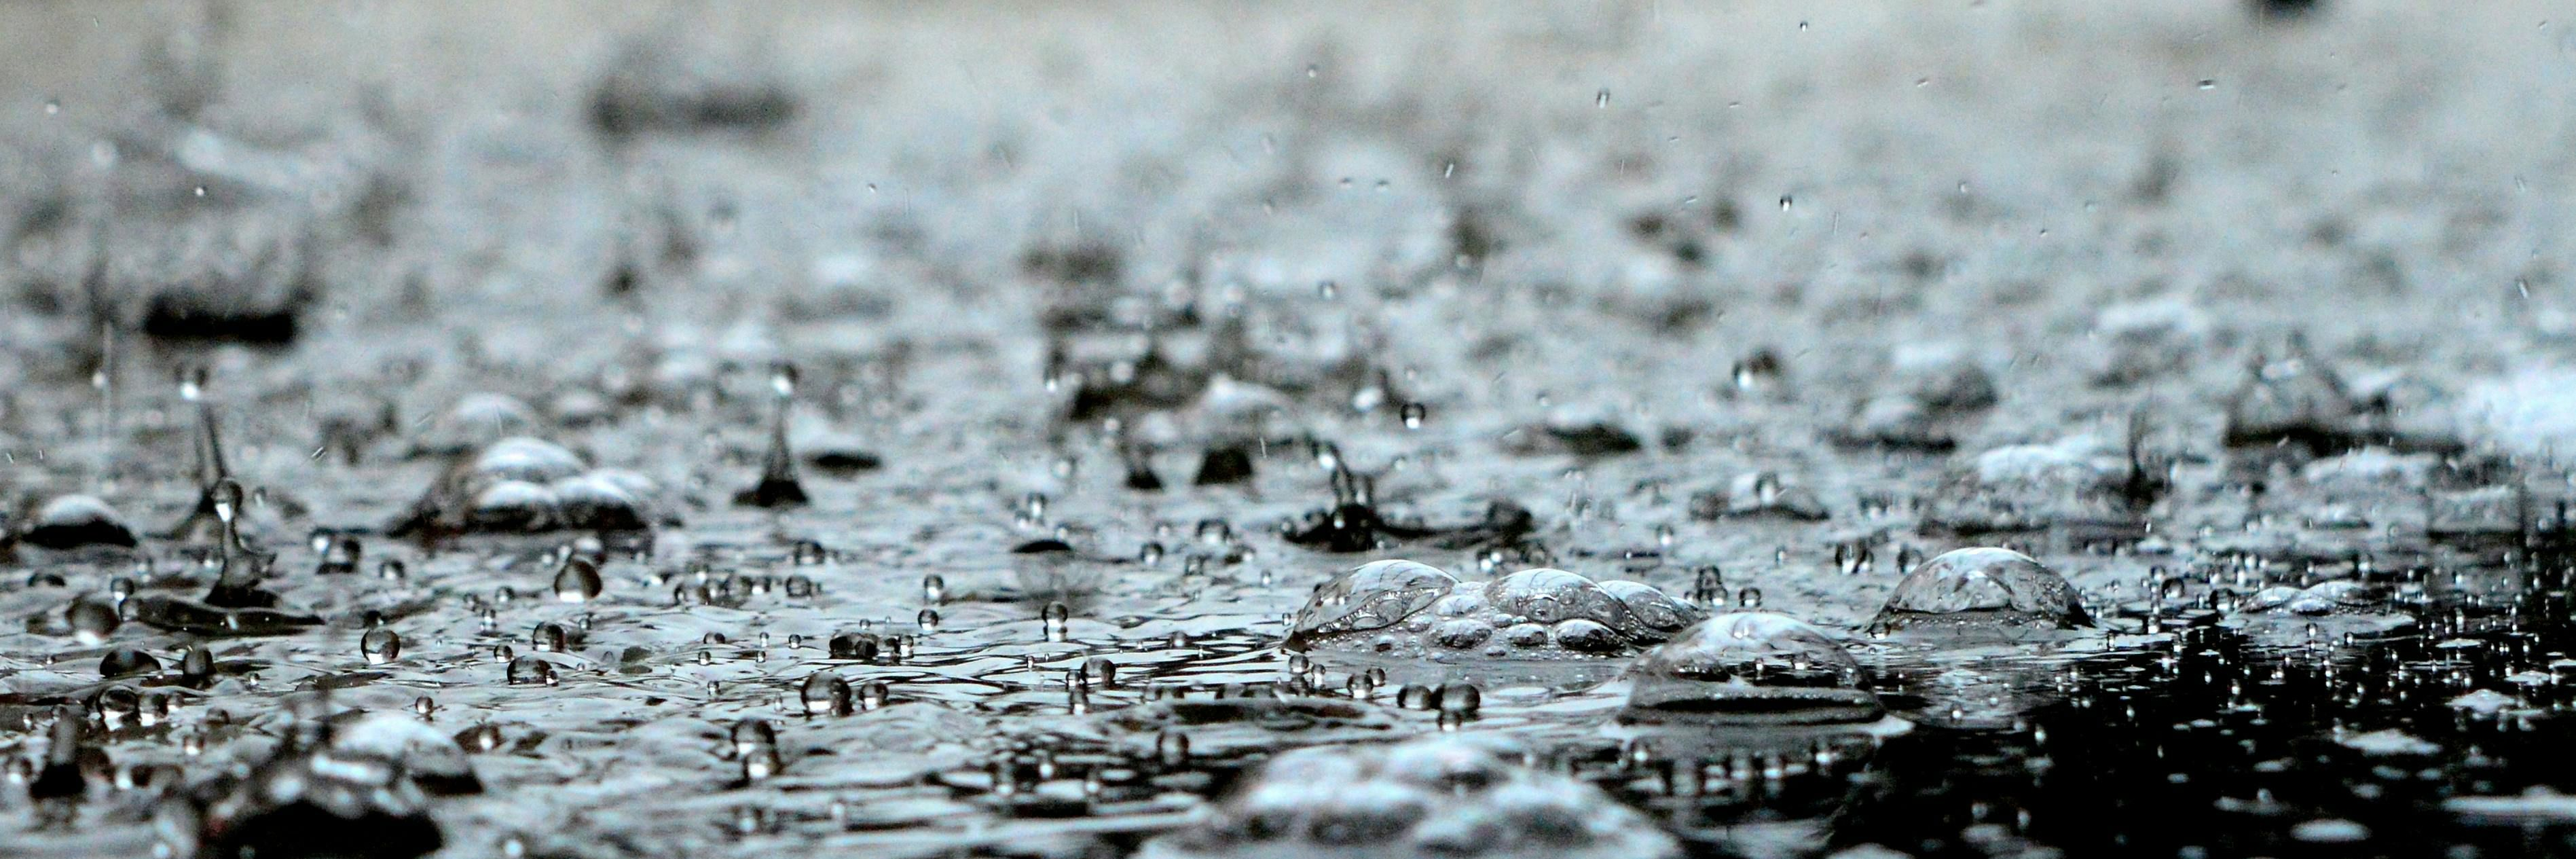


In [7]:
!pip install rasterio # rasterio is not installed on colab

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

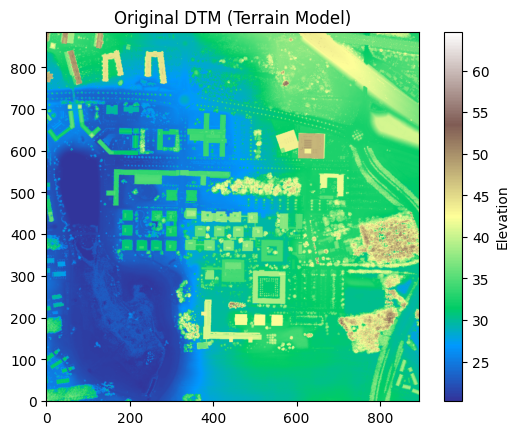

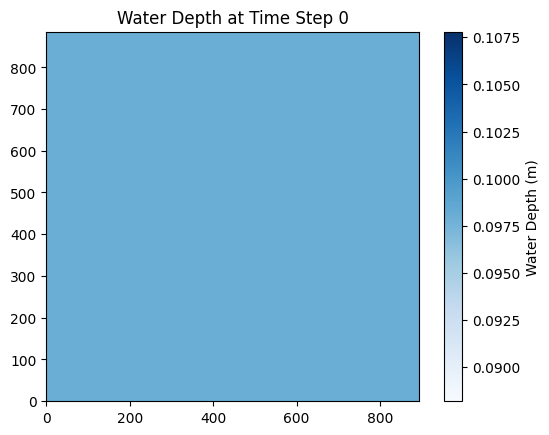

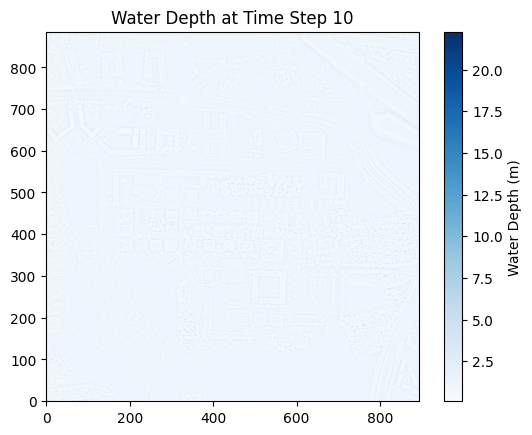

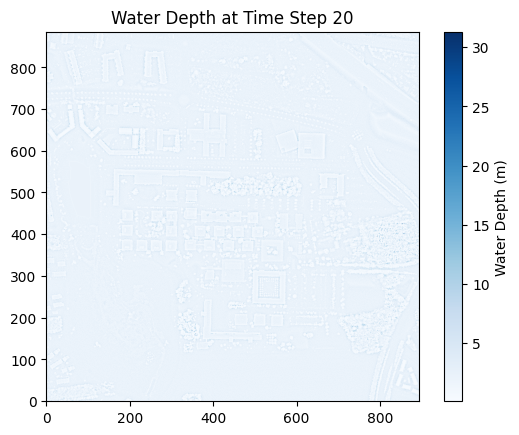

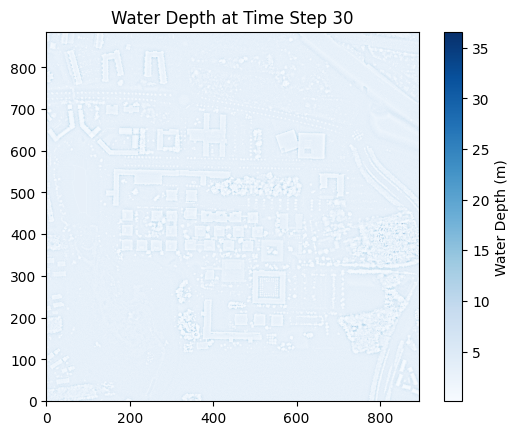

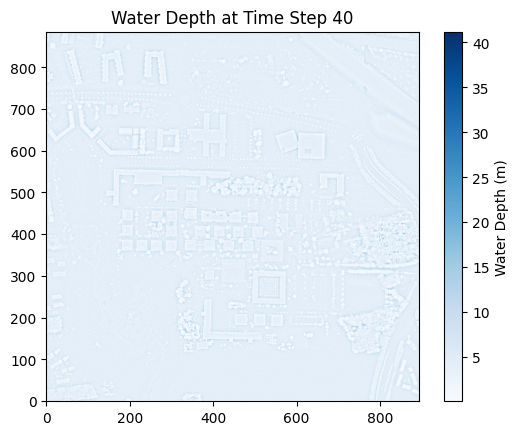

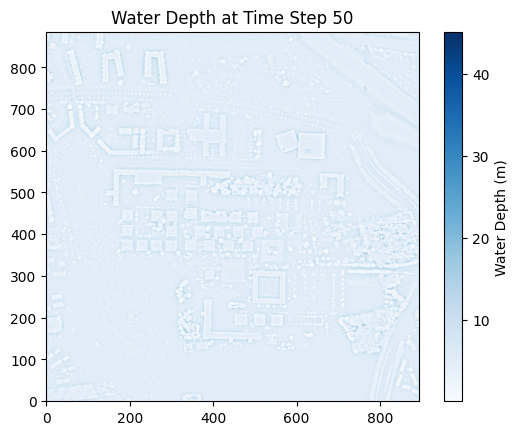

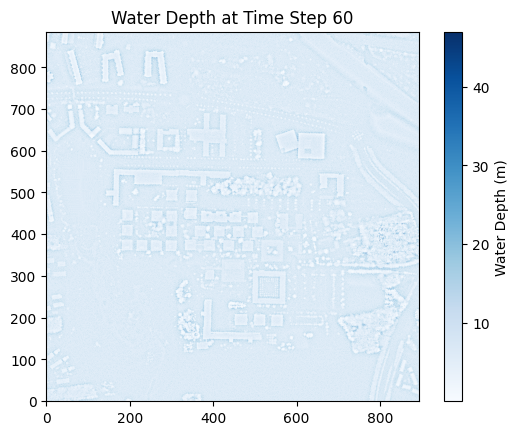

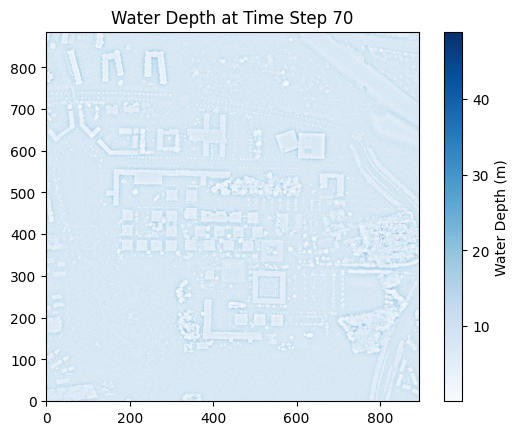

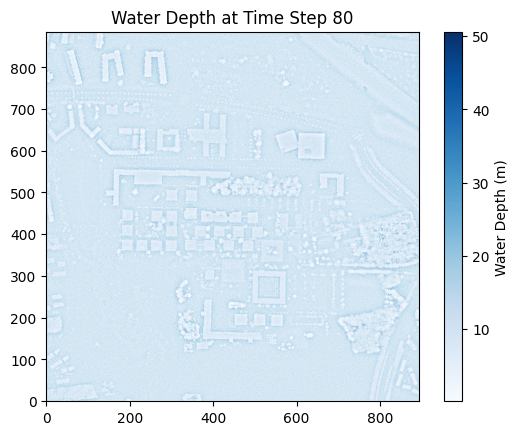

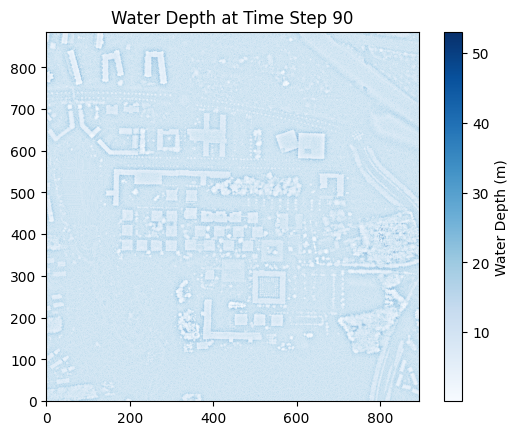

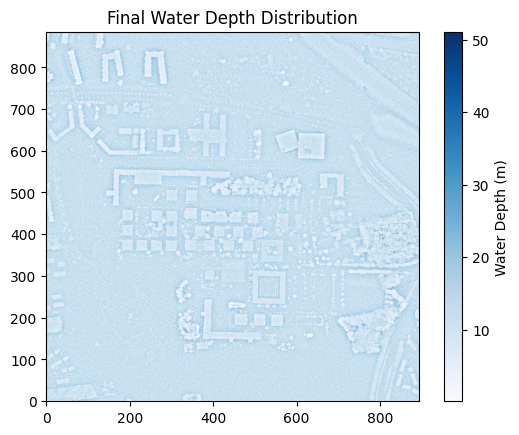

In [14]:

# -------------------------------
# GRID INITIALIZATION
# -------------------------------

# URL of the DSM file (raw file link from GitHub)
dsm_url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/ruc_dsm.tif"

# Download the file
response = requests.get(dsm_url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    dtm = src.read(1)  # Read the first (and likely only) band as a NumPy array
    profile = src.profile  # Store metadata (e.g., resolution, CRS)

nx, ny = dtm.shape  # Hent grid-størrelsen fra DTM

# Store the original DTM for visualization
original_dtm = np.copy(dtm)

# Initialize a grid for water depth (initially zero everywhere)
water_depth = np.zeros((nx, ny))

# -------------------------------
# INPUT PARAMETERS
# -------------------------------

# Rainfall per timestep (uniform rain over the grid)
rainfall = np.full((nx, ny), 0.1)  # 10 cm of rain per timestep

# Infiltration per timestep (constant for all cells)
infiltration = np.full((nx, ny), 0.002)  # 2 mm infiltration per timestep

# Number of timesteps for simulation
timesteps = 100

# -------------------------------
# NEIGHBOR IDENTIFICATION FUNCTION
# -------------------------------

def get_neighbors(i, j):
    """
    Returns the neighboring cell indices (north, south, west, east) if within bounds.
    """
    neighbors = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # N, S, W, E
        ni, nj = i + di, j + dj
        if 0 <= ni < nx and 0 <= nj < ny:
            neighbors.append((ni, nj))
    return neighbors

# -------------------------------
# VISUALIZE ORIGINAL DTM
# -------------------------------
plt.imshow(original_dtm, cmap="terrain", origin="lower")
plt.colorbar(label="Elevation")
plt.title("Original DTM (Terrain Model)")
plt.show()

# -------------------------------
# SIMULATION LOOP
# -------------------------------

# Iterate over multiple timesteps to model water accumulation and flow
for t in range(timesteps):
    # Create a new water depth grid for the next timestep
    new_water_depth = np.copy(water_depth)

    # Step 1: Add Rainfall to each cell
    new_water_depth += rainfall

    # Step 2: Apply Infiltration (cannot infiltrate more water than available in the cell)
    new_water_depth -= np.minimum(new_water_depth, infiltration)

    # Step 3: Compute Flow Between Neighboring Cells
    for i in range(nx):
        for j in range(ny):
            # Calculate the total height (terrain + water depth)
            cell_elevation = dtm[i, j] + water_depth[i, j]
            neighbors = get_neighbors(i, j)

            # Identify possible outflow to lower neighbors
            total_flow = 0
            flow_out = []
            for ni, nj in neighbors:
                neighbor_elevation = dtm[ni, nj] + water_depth[ni, nj]
                if cell_elevation > neighbor_elevation:  # Only flow downhill
                    flow_amount = (cell_elevation - neighbor_elevation) * 0.1  # Simplified flow formula
                    total_flow += flow_amount
                    flow_out.append((ni, nj, flow_amount))

            # Distribute Flow Proportionally
            if total_flow > 0:
                for ni, nj, flow_amount in flow_out:
                    transfer_amount = (flow_amount / total_flow) * water_depth[i, j]  # Ensure conservation of mass
                    new_water_depth[i, j] -= transfer_amount
                    new_water_depth[ni, nj] += transfer_amount

    # Update water depth for the next timestep
    water_depth = new_water_depth

    # -------------------------------
    # VISUALIZATION
    # -------------------------------
    if t % 10 == 0:  # Update visualization every 10 timesteps
        plt.imshow(water_depth, cmap="Blues", origin="lower")
        plt.colorbar(label="Water Depth (m)")
        plt.title(f"Water Depth at Time Step {t}")
        plt.show()

# Final visualization
plt.imshow(water_depth, cmap="Blues", origin="lower")
plt.colorbar(label="Water Depth (m)")
plt.title("Final Water Depth Distribution")
plt.show()


#Fremgangsmåde

Jeg starter med at importere de biblioteker som vi skal bruge til at lave koden:

```python
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
```

For at indlæse en TIF-fil, så gør jeg sådan her:

```python
# URL of the DSM file (raw file link from GitHub)
dsm_url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/ruc_dsm.tif"

# Download the file
response = requests.get(dsm_url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    dtm = src.read(1)  # Read the first (and likely only) band as a NumPy array
    profile = src.profile  # Store metadata (e.g., resolution, CRS)

nx, ny = dtm.shape  # Hent grid-størrelsen fra DTM

# Store the original DTM for visualization
original_dtm = np.copy(dtm)

# Initialize a grid for water depth (initially zero everywhere)
water_depth = np.zeros((nx, ny))
```

Derefter definere jeg de forskellige parameter som skal bruges i koden - mængde regn, infiltration og antal timesteps:

```python
# Rainfall per timestep (uniform rain over the grid)
rainfall = np.full((nx, ny), 0.1)  # 10 cm of rain per timestep

# Infiltration per timestep (constant for all cells)
infiltration = np.full((nx, ny), 0.002)  # 2 mm infiltration per timestep

# Number of timesteps for simulation
timesteps = 100
```

Nu definere jeg nabo-cellerne. hvert felt i vores animation tjekker op på sine naboer (op, ned, højre og venstre) for at se hvor vandet flyder hen:

```python
def get_neighbors(i, j):
    """
    Returns the neighboring cell indices (north, south, west, east) if within bounds.
    """
    neighbors = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # N, S, W, E
        ni, nj = i + di, j + dj
        if 0 <= ni < nx and 0 <= nj < ny:
            neighbors.append((ni, nj))
    return neighbors
```

Her bliver DTM'en visualiseret:

```python
plt.imshow(original_dtm, cmap="terrain", origin="lower")
plt.colorbar(label="Elevation")
plt.title("Original DTM (Terrain Model)")
plt.show()
```

Denne del af koden simulerer vandophobning og strømning over flere timesteps ved at:

- Tilføje regn til hver celle.
- Anvende infiltration, så noget af vandet forsvinder i jorden.
- Beregne vandflow mellem naboceller baseret på højdeforskel, hvor vand kun flyder nedad.
- Fordele vandet proportionalt til lavere naboceller for at sikre massen bevares.
- Opdatere vanddybden for næste tidssteg.

Dette skaber en dynamisk model som viser hvordan vand samler sig på RUC.

```python
# Iterate over multiple timesteps to model water accumulation and flow
for t in range(timesteps):
    # Create a new water depth grid for the next timestep
    new_water_depth = np.copy(water_depth)

    # Step 1: Add Rainfall to each cell
    new_water_depth += rainfall

    # Step 2: Apply Infiltration (cannot infiltrate more water than available in the cell)
    new_water_depth -= np.minimum(new_water_depth, infiltration)

    # Step 3: Compute Flow Between Neighboring Cells
    for i in range(nx):
        for j in range(ny):
            # Calculate the total height (terrain + water depth)
            cell_elevation = dtm[i, j] + water_depth[i, j]
            neighbors = get_neighbors(i, j)

            # Identify possible outflow to lower neighbors
            total_flow = 0
            flow_out = []
            for ni, nj in neighbors:
                neighbor_elevation = dtm[ni, nj] + water_depth[ni, nj]
                if cell_elevation > neighbor_elevation:  # Only flow downhill
                    flow_amount = (cell_elevation - neighbor_elevation) * 0.1  # Simplified flow formula
                    total_flow += flow_amount
                    flow_out.append((ni, nj, flow_amount))

            # Distribute Flow Proportionally
            if total_flow > 0:
                for ni, nj, flow_amount in flow_out:
                    transfer_amount = (flow_amount / total_flow) * water_depth[i, j]  # Ensure conservation of mass
                    new_water_depth[i, j] -= transfer_amount
                    new_water_depth[ni, nj] += transfer_amount

    # Update water depth for the next timestep
    water_depth = new_water_depth
```

Denne del af koden skaber selve visualiseringen - ved at lave en model som viser hvert 10. timestep, der kommer derfor 10 visualiseringer:

```python
    if t % 10 == 0:  # Update visualization every 10 timesteps
        plt.imshow(water_depth, cmap="Blues", origin="lower")
        plt.colorbar(label="Water Depth (m)")
        plt.title(f"Water Depth at Time Step {t}")
        plt.show()

# Final visualization
plt.imshow(water_depth, cmap="Blues", origin="lower")
plt.colorbar(label="Water Depth (m)")
plt.title("Final Water Depth Distribution")
plt.show()
```